In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [19]:
# Load and preprocess the data
def load_and_preprocess_data(file_path):
    df = pd.read_excel(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)
    if df.isnull().sum().any():
        df = df.interpolate(method='time')
    return df

# Load dataset
file_path = 'TSLA_hourly_processed_without_NAN.xlsx'
df = load_and_preprocess_data(file_path)

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3280 entries, 2023-05-15 17:30:00 to 2025-04-01 19:30:00
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               3280 non-null   float64
 1   High               3280 non-null   float64
 2   Low                3280 non-null   float64
 3   Close              3280 non-null   float64
 4   Volume             3280 non-null   int64  
 5   SMA_5              3280 non-null   float64
 6   SMA_20             3280 non-null   float64
 7   SMA_50             3280 non-null   float64
 8   SMA_200            3280 non-null   float64
 9   EMA_5              3280 non-null   float64
 10  EMA_20             3280 non-null   float64
 11  EMA_50             3280 non-null   float64
 12  EMA_200            3280 non-null   float64
 13  RSI                3280 non-null   float64
 14  ATR                3280 non-null   float64
 15  MACD               328

In [20]:
# Feature selection and scaling
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_20', 'SMA_50', 
            'SMA_200', 'EMA_5', 'EMA_20', 'EMA_50', 'EMA_200', 'RSI', 'ATR', 
            'MACD', 'MACD_Signal', 'Bollinger_Upper', 'Bollinger_Mid', 
            'Bollinger_Lower', 'VWAP', 'Candle_Width', '% Change', 'OBV', 
            'Cumulative_Return']
target = 'Close'

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])


In [21]:
# Prepare data for RNN
def prepare_rnn_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps - 1):
        X.append(data[i:(i + n_steps), :-1])
        y.append(data[i + n_steps, -1])
    return np.array(X), np.array(y)

n_steps = 24
X, y = prepare_rnn_data(scaled_data, n_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))



Training RNN Model...
Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2231 - val_loss: 0.0445
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0523 - val_loss: 0.0373
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0253 - val_loss: 0.0177
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0164 - val_loss: 0.0117
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0120 - val_loss: 0.0138
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0096 - val_loss: 0.0110
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0073 - val_loss: 0.0109
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0057 - val_loss: 0.0128
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0050 - val_loss: 0.0139
Epoch 10/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0046 - val_loss: 0.0094
Epoch 11/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043 - val_loss: 0.0069
Epoch 12/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1

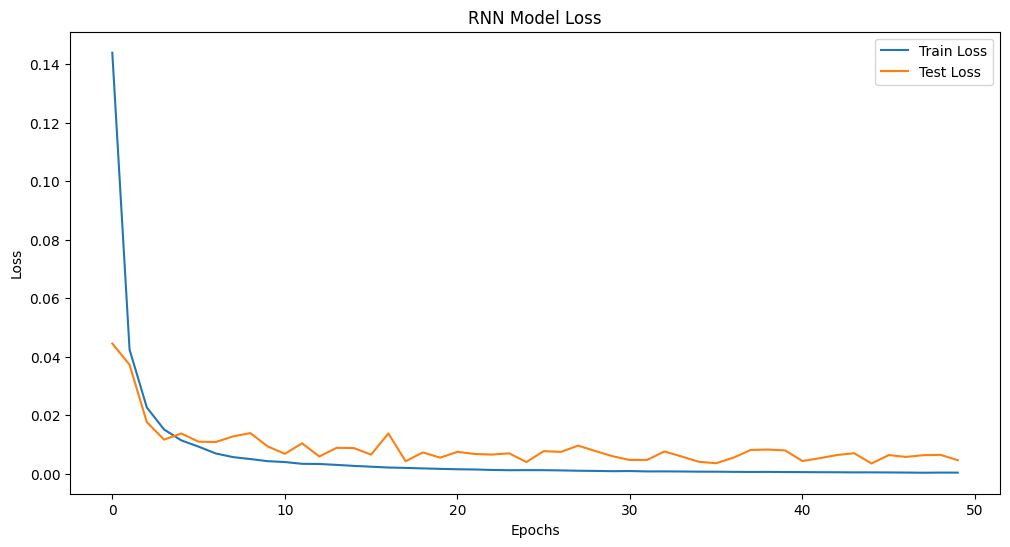

In [22]:
# Build and train RNN model
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        SimpleRNN(100),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

print("\nTraining RNN Model...")
rnn_model = build_rnn_model((X_train.shape[1], X_train.shape[2]))
history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                        validation_data=(X_test, y_test), verbose=1)

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
# PyTorch Dataset
class FinancialDataset(Dataset):
    def __init__(self, data, features, target, seq_length=24):
        self.data = data[features + [target]].values
        self.seq_length = seq_length
        self.scaler = MinMaxScaler()
        self.scaled_data = self.scaler.fit_transform(self.data)
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        x = self.scaled_data[idx:idx + self.seq_length]
        y = self.scaled_data[idx + self.seq_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Create loaders
clm_dataset = FinancialDataset(df.reset_index(), features, target)
train_size = int(0.8 * len(clm_dataset))
train_dataset, val_dataset = torch.utils.data.random_split(clm_dataset, [train_size, len(clm_dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



Training Transformer Model...
Epoch 1/20 - Train: 0.068963, Val: 0.021361
Epoch 2/20 - Train: 0.014714, Val: 0.010207
Epoch 3/20 - Train: 0.007576, Val: 0.005424
Epoch 4/20 - Train: 0.004576, Val: 0.003642
Epoch 5/20 - Train: 0.003446, Val: 0.002842
Epoch 6/20 - Train: 0.002856, Val: 0.002475
Epoch 7/20 - Train: 0.002517, Val: 0.002107
Epoch 8/20 - Train: 0.002206, Val: 0.001834
Epoch 9/20 - Train: 0.001995, Val: 0.001765
Epoch 10/20 - Train: 0.001822, Val: 0.001579
Epoch 11/20 - Train: 0.001727, Val: 0.001453
Epoch 12/20 - Train: 0.001628, Val: 0.001402
Epoch 13/20 - Train: 0.001550, Val: 0.001350
Epoch 14/20 - Train: 0.001467, Val: 0.001261
Epoch 15/20 - Train: 0.001405, Val: 0.001202
Epoch 16/20 - Train: 0.001278, Val: 0.001084
Epoch 17/20 - Train: 0.001153, Val: 0.000969
Epoch 18/20 - Train: 0.001090, Val: 0.000900
Epoch 19/20 - Train: 0.001038, Val: 0.000863
Epoch 20/20 - Train: 0.001000, Val: 0.000865


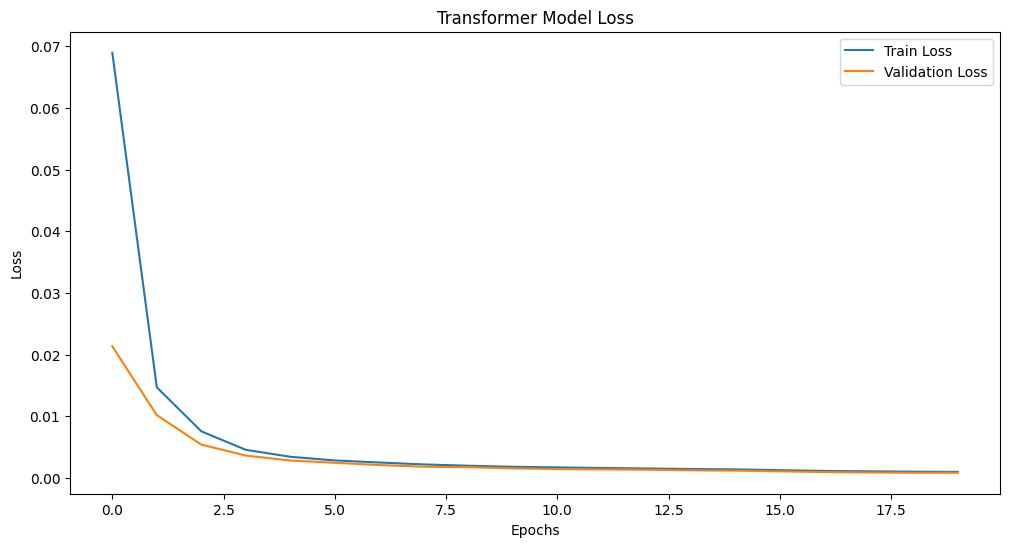

In [24]:
# Transformer Model
class FinancialTransformer(nn.Module):
    def __init__(self, config, num_features):
        super().__init__()
        self.embedding = nn.Linear(num_features, config['n_embd'])
        self.position_embeddings = nn.Embedding(config['n_positions'], config['n_embd'])
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config['n_embd'], nhead=config['n_head'],
            dim_feedforward=config['n_inner'], dropout=config['resid_pdrop'],
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, config['n_layer'])
        self.head = nn.Linear(config['n_embd'], num_features)
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
    
    def forward(self, x):
        batch_size, seq_length, _ = x.shape
        position_ids = torch.arange(seq_length, dtype=torch.long, device=x.device).unsqueeze(0).expand(batch_size, -1)
        inputs_embeds = self.embedding(x)
        position_embeds = self.position_embeddings(position_ids)
        hidden_states = inputs_embeds + position_embeds
        hidden_states = hidden_states.permute(1, 0, 2)
        transformer_outputs = self.transformer(hidden_states)
        last_hidden = transformer_outputs[-1]
        prediction = self.head(last_hidden)
        return prediction

# Config
config = {
    'n_positions': 24, 'n_embd': 64, 'n_layer': 4,
    'n_head': 4, 'n_inner': 256, 'resid_pdrop': 0.1,
    'attn_pdrop': 0.1, 'embd_pdrop': 0.1
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_features = len(features) + 1
model = FinancialTransformer(config, num_features).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
print("\nTraining Transformer Model...")
num_epochs = 20
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            epoch_val_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    val_losses.append(epoch_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs} - Train: {train_losses[-1]:.6f}, Val: {val_losses[-1]:.6f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Transformer Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

 Model Evaluation Metrics:
 RNN - MSE: 0.004675, RMSE: 0.068374, MAE: 0.055828
 Transformer - MSE: 0.000276, RMSE: 0.016616, MAE: 0.011821


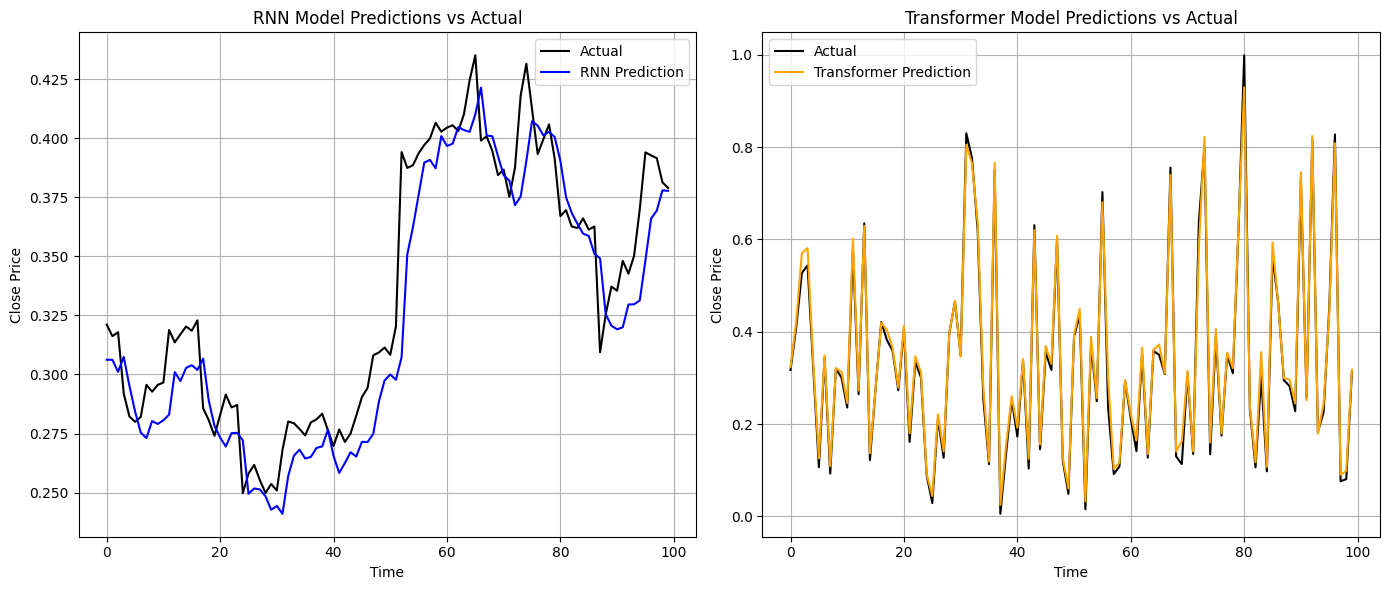

In [28]:
# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# RNN evaluation
y_pred_rnn = rnn_model.predict(X_test).flatten()
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mae_rnn = mean_absolute_error(y_test, y_pred_rnn)

# Transformer evaluation
model.eval()
y_true_trans, y_pred_trans = [], []
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        y_true_trans.append(y_batch.cpu().numpy())
        y_pred_trans.append(preds.cpu().numpy())

y_true_trans = np.concatenate(y_true_trans)[:, -1]  # Close price
y_pred_trans = np.concatenate(y_pred_trans)[:, -1]
mse_trans = mean_squared_error(y_true_trans, y_pred_trans)
rmse_trans = np.sqrt(mse_trans)
mae_trans = mean_absolute_error(y_true_trans, y_pred_trans)

# Print metrics
print("\n Model Evaluation Metrics:")
print(f" RNN - MSE: {mse_rnn:.6f}, RMSE: {rmse_rnn:.6f}, MAE: {mae_rnn:.6f}")
print(f" Transformer - MSE: {mse_trans:.6f}, RMSE: {rmse_trans:.6f}, MAE: {mae_trans:.6f}")


import matplotlib.pyplot as plt

n_plot = 100

plt.figure(figsize=(14, 6))

#  RNN
plt.subplot(1, 2, 1)
plt.plot(y_test[-n_plot:], label='Actual', color='black')
plt.plot(y_pred_rnn[-n_plot:], label='RNN Prediction', color='blue')
plt.title('RNN Model Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

#  Transformer
plt.subplot(1, 2, 2)
plt.plot(y_true_trans[-n_plot:], label='Actual', color='black')
plt.plot(y_pred_trans[-n_plot:], label='Transformer Prediction', color='orange')
plt.title('Transformer Model Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
